In [2]:
import pvml
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import joblib
import matplotlib.pyplot as plt

In [3]:
def meanvar_normalization ( Xtrain , Xtest ) :
    mu = Xtrain . mean (0)
    sigma = Xtrain . std (0)
    Xtrain = ( Xtrain - mu ) / sigma
    Xtest = ( Xtest - mu ) / sigma
    return Xtrain , Xtest 

def minmax_normalization ( Xtrain , Xtest ) :   
    xmin = Xtrain .min (0)    
    xmax = Xtrain .max (0)
    Xtrain = ( Xtrain - xmin ) / ( xmax - xmin )
    Xtest = ( Xtest - xmin ) / ( xmax - xmin )
    return Xtrain , Xtest 

def maxabs_normalization ( Xtrain , Xtest ) :
    amax = np .abs ( Xtrain ) .max (0)
    Xtrain = Xtrain / amax
    Xtest = Xtest / amax
    return Xtrain , Xtest 

### Load features of 300k dataset and split in train and test data

In [4]:

# Load the features from 'features_reviews.csv'
features = pd.read_csv('features_reviews.csv').dropna(subset=['rating'])

# Create a pandas Series
series = pd.Series(features['feature_vector'])

# Split each line into multiple values
split_values = series.str.split(',')

# Split the Series into columns
X = split_values.apply(lambda x: pd.Series([item.strip('[] ') for item in x]))

# Convert X to float values
X = X.astype(float)


Y = features['rating']




# Split the data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

# MINMAX NORMALIZATION
#Xtrain , Xtest = minmax_normalization(Xtrain,Xtest)

print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)




(203478, 100)
(203478,)
(50870, 100)
(50870,)


Count of unique values in 'rating' column:
10.0    59965
8.0     36486
9.0     31045
7.0     30411
1.0     24403
6.0     21708
5.0     16257
4.0     12177
3.0     11309
2.0     10587
Name: rating, dtype: int64


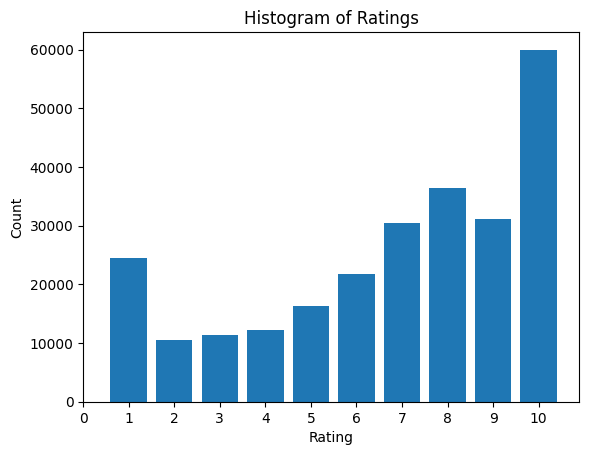

In [12]:

# Get the count of each unique value in the 'rating' column
value_counts = Y.value_counts()

# Print the count of unique values
print("Count of unique values in 'rating' column:")
print(value_counts)

# Create the histogram
plt.bar(value_counts.index, value_counts)

# Set custom labels on the x-axis
plt.xticks(range(len(value_counts.index)+1))

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Histogram of Ratings ()')

# Show the plot
plt.show()



### Train MLP and prediction

In [24]:
# Instantiate the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='adam', random_state=42)

# Train the model
mlp.fit(Xtrain, Ytrain)

# Step 4: Evaluate the trained model

print(Xtest)

# Make predictions on the test dataset
Ypred = mlp.predict(Xtest)

/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


              0         1         2         3         4         5         6   \
194728  0.192281  0.751074 -0.738896 -0.798254 -0.258602  1.695870 -1.793883   
3696    0.267188  0.840417 -1.119097 -0.812290 -0.311270  1.324513 -1.536110   
64340   0.267446  0.208766 -0.640100 -0.718523 -0.238676  1.096416 -1.260673   
105405  0.472772  1.113330 -0.685132 -0.694947 -0.348765  1.529818 -1.949172   
43368   0.165288  0.557895 -0.897680 -1.051838 -0.081996  1.027811 -1.407085   
...          ...       ...       ...       ...       ...       ...       ...   
284104 -0.054863  0.828633 -0.994290 -0.782276 -0.237041  1.523060 -1.867379   
271188  0.397420  0.671843 -0.823572 -0.820867 -0.259866  1.214292 -1.738535   
258535  0.342468  0.362590 -0.946846 -0.965312 -0.354211  1.232233 -1.958442   
170289  0.239696  0.639170 -0.887228 -0.886941 -0.539135  1.376649 -1.554884   
261831  0.430407  0.479117 -1.218097 -0.766283 -0.280506  1.143265 -1.629199   

              7         8         9   .

### Print different accuracies

In [25]:
# Evaluate the model performance
#accuracy = accuracy_score(Ytest, Ypred)
#print("Accuracy:", accuracy)


# Calculate the accuracy with a variation of +/-1
accuracy = sum(abs(Ytest - Ypred) <= 1) / len(Ytest)
print("Accuracy with +/-1 variation:", round(accuracy*100,2) ,"%")

# Calculate the accuracy with a variation of +/-2
accuracy = sum(abs(Ytest - Ypred) <= 2) / len(Ytest)
print("Accuracy with +/-2 variation:", round(accuracy*100,2) ,"%")

# Calculate the accuracy with a variation of +/-4
accuracy = sum(abs(Ytest - Ypred) <= 4) / len(Ytest)
print("Accuracy with +/-4 variation:", round(accuracy*100,2) ,"%")

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(Ytest, Ypred))
print("RMSE:", rmse)

Accuracy with +/-1 variation: 61.66 %
Accuracy with +/-2 variation: 78.96 %
Accuracy with +/-4 variation: 91.98 %
RMSE: 2.5200629982670897


### Histogram of errors


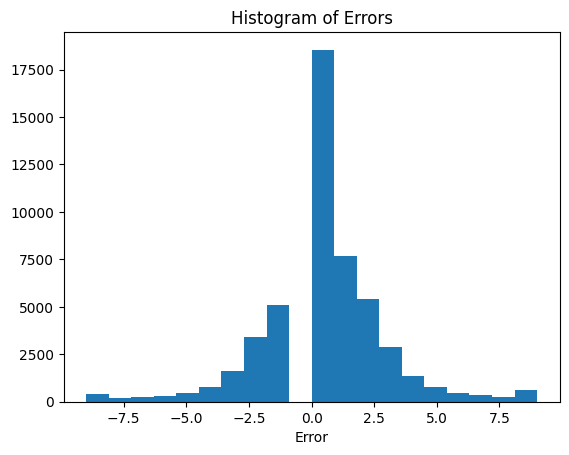

In [26]:
# Visualize the errors
errors = Ypred - Ytest
# Plot the histogram of errors
plt.hist(errors, bins=20) 
plt.xlabel('Error')
plt.title('Histogram of Errors')
plt.show()

### Save MLP weights

In [27]:
joblib.dump(mlp, 'mlp_weights.pkl')

['mlp_weights.pkl']

### Use MLP to predict missing ratings in 10k dataset


In [28]:
import pymongo

# Connect to MongoDB and select the database 
mongo = pymongo.MongoClient()
mongo_db = mongo.project
# Load the reviews from the reviews collection 
data = pd.DataFrame(list(mongo_db.noRatings.find({}, {'_id': False})))
#Close the connection
mongo.close() 
print(data.shape)


# Load the features from 'features.csv'
features = pd.read_csv('features_noRatings.csv')

# Create a pandas Series
series = pd.Series(features['feature_vector'])


# Split each line into multiple values
split_values = series.str.split(',')

# Split the Series into columns
X = split_values.apply(lambda x: pd.Series([item.strip('[] ') for item in x]))

# Convert X to float values
X = X.astype(float)


Y = features['rating']


# Load the already trained MLP model
mlp = joblib.load('mlp_weights.pkl')



predictions = mlp.predict(X)

# Replace the 'City' column with the new values
data['rating'] = predictions


# Get the count of each unique value in the 'rating' column
value_counts = data['rating'].value_counts()

# Print the count of unique values
print("Count of unique values in 'rating' column:")
print(value_counts)

data.to_csv('data.csv', index=False)




(9957, 11)
Count of unique values in 'rating' column:
10.0    4272
7.0     1503
1.0     1425
8.0     1190
6.0      856
5.0      445
4.0      154
3.0       58
9.0       44
2.0       10
Name: rating, dtype: int64


### Confusion matrix of the 300k dataset (will be done on 203478 lines)

In [29]:
from sklearn.metrics import confusion_matrix


# Connect to MongoDB and select the database 
mongo = pymongo.MongoClient()
mongo_db = mongo.project
# Load the reviews from the reviews collection 
data = pd.DataFrame(list(mongo_db.reviews.find({}, {'_id': False})))
#Close the connection
mongo.close() 
print(data.shape)


features = pd.read_csv('features_reviews.csv').dropna(subset=['rating'])

# Create a pandas Series
series = pd.Series(features['feature_vector'])


# Split each line into multiple values
split_values = series.str.split(',')

# Split the Series into columns
X = split_values.apply(lambda x: pd.Series([item.strip('[] ') for item in x]))

# Convert X to float values
X = X.astype(float)


Y = features['rating']


# Load the already trained MLP model
mlp = joblib.load('mlp_weights.pkl')



predictions = mlp.predict(X)



# Create the confusion matrix
confusion_mat = confusion_matrix(Y, predictions)

# Print the confusion matrix
print(confusion_mat)


(300639, 11)
[[18654    45   233   480   769   580   486   254    16  2886]
 [ 6175    80   285   534   914   684   478   229     9  1199]
 [ 4974    46   393   751  1427  1217   856   335    16  1294]
 [ 3272    34   262   835  1850  2253  1576   546    20  1529]
 [ 2716    38   222   708  2343  3446  3241  1106    40  2397]
 [ 1792     9   130   458  1916  4694  6287  2769    59  3594]
 [ 1328     5    83   228  1176  3735  9349  6008   181  8318]
 [ 1155     4    29   122   702  1976  7304  8452   343 16399]
 [  908     4    14    59   302   881  3368  5344   421 19744]
 [ 1878     1    30    78   333   677  2581  4705   325 49357]]


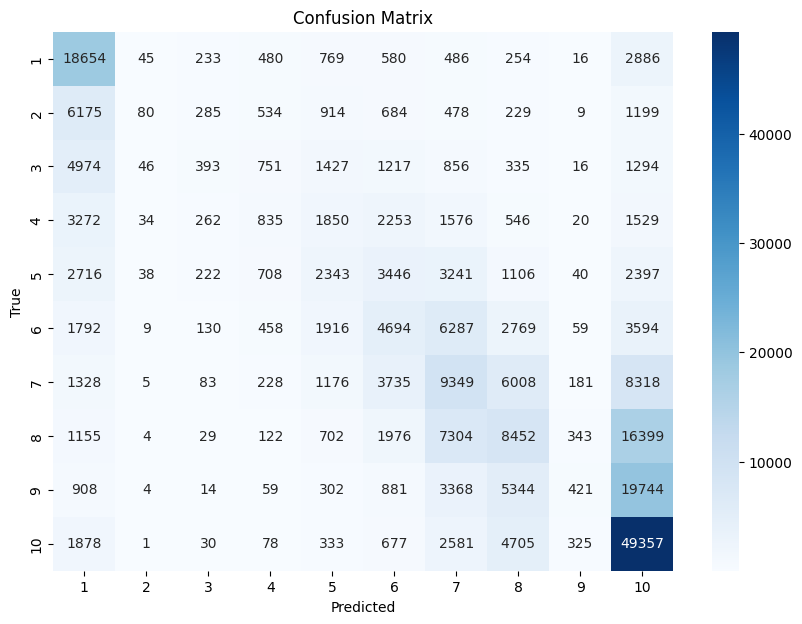

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt


# Define the rating labels
rating_labels = list(range(1, 11))

# Create the confusion matrix
confusion_mat = confusion_matrix(Y, predictions, labels=rating_labels)

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(confusion_mat, index=rating_labels, columns=rating_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Show the plot
plt.show()